<h1><center>

</center></h1>
<font size="6"><center>
EIE 401
PROCESAMIENTO DIGITAL MULTIMEDIA 
</center></font>


<center><h2>Proyecto 2</h2></center>
<center><h3>Procesamiento digital de señales</h3></center>
<center><h3>Profesor: Jorge Cardenas</h3></center>

<center><h3>Por: José Alvarado Espinoza</h3></center>
<center><h5>Pontificia Universidad Catolica de Valparaiso</h5></center>
 

In [4]:
from IPython.display import IFrame, display
#filepath = "Proyecto_2_EIE401.pdf"
#IFrame(filepath, width=700, height=400)

En la dirección https://huggingface.co/datasets/astroboy1/metasurfaces_V1_30-90GHZ encontrarás el archivo batch_june2024.zip que contiene las imagenes que usarás para el procesamiento. ATENCION: usa el archivo zip indicado pues tienes las imagenes preparadas para tu trabajo.

## 1. Carga de Datos


- En los archivos, encontrarás un folder con imagenes de 3 categorías: cross, box, circle.
Cada imagen tiene una medida de 512x512 pixeles y 3 canales. Se han acentuado los azules y rojos para facilitar el proceso de obtención de características.

- Puedes extraer la clase a la que pertenece la imagen, desde el nombre del archivo. Ahí mismo encuentras números de serie que te permiten identificar de forma específica una imagen.

- Se te entrega 3 imagenes de referencia de 32x32 pixeles, las que debes usar como plantilla para el proceso de clasificación de la imagen.


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from PIL import Image
import os
import cv2


box_ref = cv2.imread("box_templae.png")
circ_ref = cv2.imread("circ_templae.png")
cross_ref = cv2.imread("cross_templae.png")

# Obtener dimensiones de las imágenes
box_height, box_width = box_ref.shape[:2]
circ_height, circ_width = circ_ref.shape[:2]
cross_height, cross_width = cross_ref.shape[:2]

# Imprimir dimensiones
print(f"Tamaño de box_ref: {box_width}x{box_height} (ancho x alto)")
print(f"Tamaño de circ_ref: {circ_width}x{circ_height} (ancho x alto)")
print(f"Tamaño de cross_ref: {cross_width}x{cross_height} (ancho x alto)")

# Carpeta en la que se almacenan las imagenes iniciales
carpeta_principal = "processed512"


# Prefijos utilizados para almacenar las imagenes, importante para saber el numero de errores que tendremos en nuestro procesamiento.
box_prefix = "box"
circ_prefix = "circ"
cross_prefix = "cross"



Tamaño de box_ref: 16x16 (ancho x alto)
Tamaño de circ_ref: 16x16 (ancho x alto)
Tamaño de cross_ref: 16x16 (ancho x alto)


## 2. Transformar imagen
Recuerda que la tarea es lograr el procesamiento más rápido posible.
Para lograr esto, realiza las operaciones que consideres necesarias sobre la imagen original para el posterior trabajo de Matching con las plantillas dadas. Crees que trabajar en el dominio de fourier o wavelet ayudaría en las etapas posteriores?

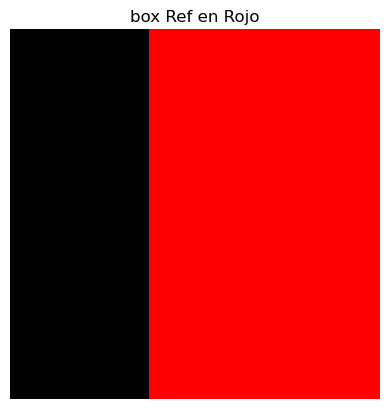

In [10]:
# transformaremos las imagenes de referencia a diferentes escalas quedandono con diferentes canales para trabajar en diferentes grados segun corresponda
# esperando esto haga mas rapido el procesamiento.

box_red = np.zeros_like(box_ref)
box_red[:, :, 2] = box_ref[:, :, 2]  # Canal Azul


plt.imshow(cv2.cvtColor(box_red, cv2.COLOR_BGR2RGB))
plt.title('box Ref en Rojo')
plt.axis('off')
plt.show()


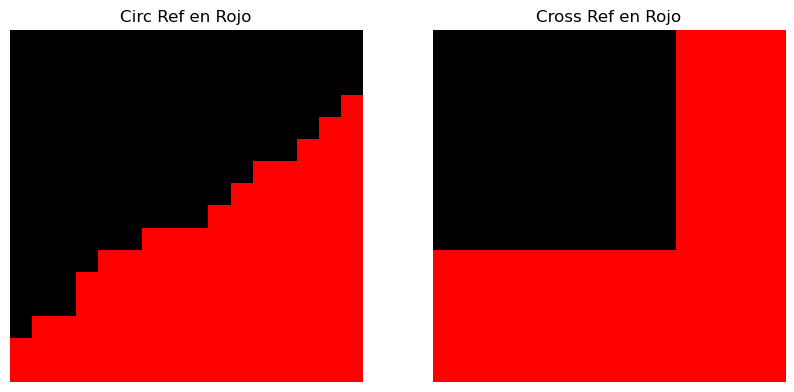

In [11]:
# Ahora haremos que tanto cruz como circulo trabajen en solo un canal ya sea R o B para asi ver si logramos aplicar ambas transformaciones al mismo tiempo
# y calcularla en diferentes niveles.
circ_red = np.zeros_like(circ_ref)
circ_red[:, :, 2] = circ_ref[:, :, 2]  # Canal Rojo

cross_red = np.zeros_like(cross_ref)
cross_red[:, :, 2] = cross_ref[:, :, 2]  # Canal Rojo

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(circ_red, cv2.COLOR_BGR2RGB))
plt.title('Circ Ref en Rojo')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(cross_red, cv2.COLOR_BGR2RGB))
plt.title('Cross Ref en Rojo')
plt.axis('off')

plt.show()

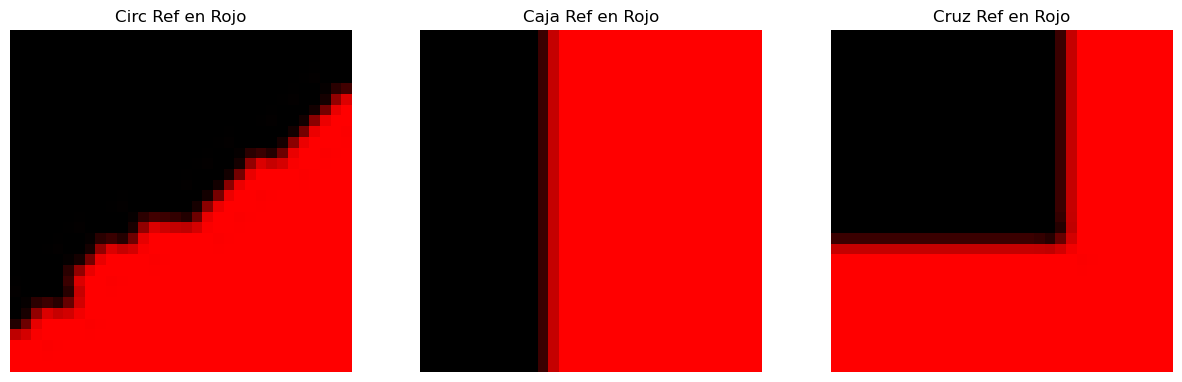

In [12]:
import cv2
import matplotlib.pyplot as plt

# Escalar las imágenes a 32x32 píxeles usando interpolación bicúbica
caja = cv2.resize(box_red, (32, 32), interpolation=cv2.INTER_CUBIC)
circ = cv2.resize(circ_red, (32, 32), interpolation=cv2.INTER_CUBIC)
cruz = cv2.resize(cross_red, (32, 32), interpolation=cv2.INTER_CUBIC)

# Crear la carpeta "plantillas" si no existe
carpeta_plantillas = "plantillas"
if not os.path.exists(carpeta_plantillas):
    os.makedirs(carpeta_plantillas)

# Guardar las imágenes escaladas en la carpeta "plantillas"
cv2.imwrite(os.path.join(carpeta_plantillas, "box.png"), caja)
cv2.imwrite(os.path.join(carpeta_plantillas, "circ.png"), circ)
cv2.imwrite(os.path.join(carpeta_plantillas, "cross.png"), cruz)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(cv2.cvtColor(circ, cv2.COLOR_BGR2RGB))
plt.title('Circ Ref en Rojo')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(cv2.cvtColor(caja, cv2.COLOR_BGR2RGB))
plt.title('Caja Ref en Rojo')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(cv2.cvtColor(cruz, cv2.COLOR_BGR2RGB))
plt.title('Cruz Ref en Rojo')
plt.axis('off')

plt.show()

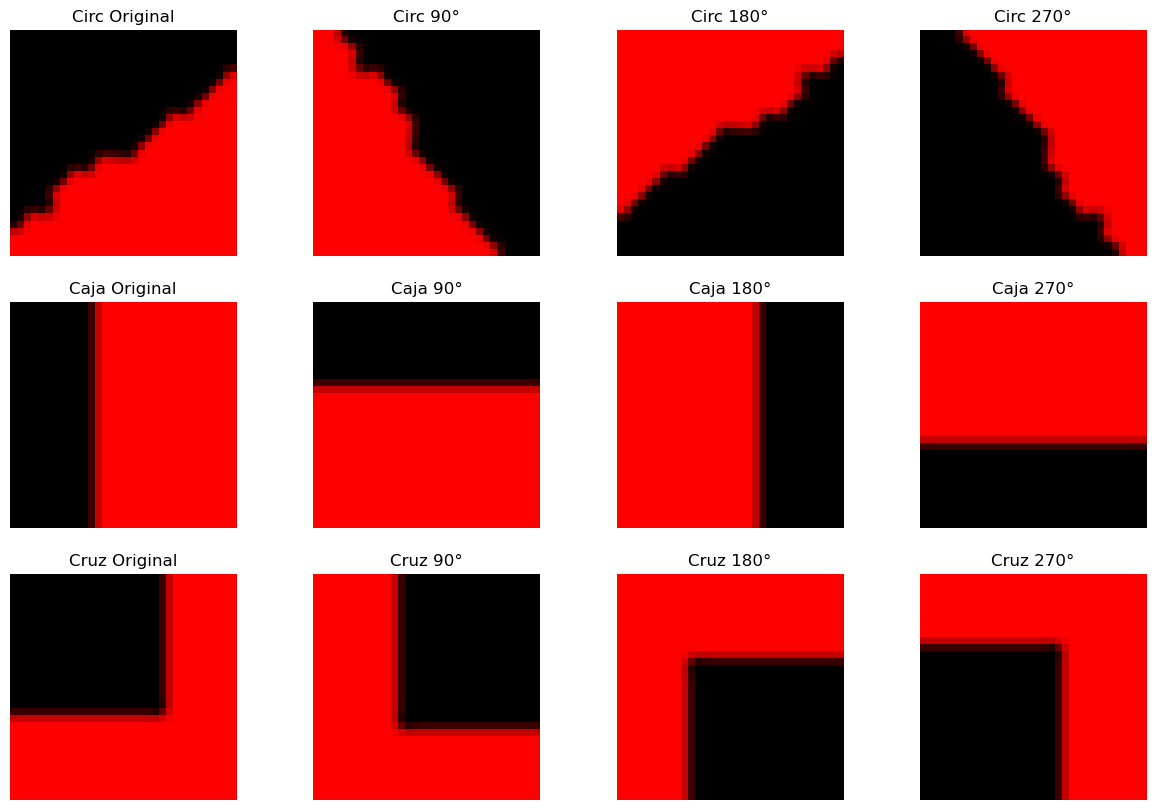

In [13]:
import cv2
import matplotlib.pyplot as plt

# Suponiendo que las imágenes redimensionadas ya están cargadas como caja, circ, cruz
caja = cv2.resize(box_red, (32, 32), interpolation=cv2.INTER_CUBIC)
circ = cv2.resize(circ_red, (32, 32), interpolation=cv2.INTER_CUBIC)
cruz = cv2.resize(cross_red, (32, 32), interpolation=cv2.INTER_CUBIC)

# Rotar las imágenes
caja_90 = cv2.rotate(caja, cv2.ROTATE_90_CLOCKWISE)
caja_180 = cv2.rotate(caja, cv2.ROTATE_180)
caja_270 = cv2.rotate(caja, cv2.ROTATE_90_COUNTERCLOCKWISE)

circ_90 = cv2.rotate(circ, cv2.ROTATE_90_CLOCKWISE)
circ_180 = cv2.rotate(circ, cv2.ROTATE_180)
circ_270 = cv2.rotate(circ, cv2.ROTATE_90_COUNTERCLOCKWISE)

cruz_90 = cv2.rotate(cruz, cv2.ROTATE_90_CLOCKWISE)
cruz_180 = cv2.rotate(cruz, cv2.ROTATE_180)
cruz_270 = cv2.rotate(cruz, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Mostrar las imágenes originales y rotadas
fig, axs = plt.subplots(3, 4, figsize=(15, 10))

# Imagen original y rotadas para circ
axs[0, 0].imshow(cv2.cvtColor(circ, cv2.COLOR_BGR2RGB))
axs[0, 0].set_title('Circ Original')
axs[0, 0].axis('off')

axs[0, 1].imshow(cv2.cvtColor(circ_90, cv2.COLOR_BGR2RGB))
axs[0, 1].set_title('Circ 90°')
axs[0, 1].axis('off')

axs[0, 2].imshow(cv2.cvtColor(circ_180, cv2.COLOR_BGR2RGB))
axs[0, 2].set_title('Circ 180°')
axs[0, 2].axis('off')

axs[0, 3].imshow(cv2.cvtColor(circ_270, cv2.COLOR_BGR2RGB))
axs[0, 3].set_title('Circ 270°')
axs[0, 3].axis('off')

# Imagen original y rotadas para caja
axs[1, 0].imshow(cv2.cvtColor(caja, cv2.COLOR_BGR2RGB))
axs[1, 0].set_title('Caja Original')
axs[1, 0].axis('off')

axs[1, 1].imshow(cv2.cvtColor(caja_90, cv2.COLOR_BGR2RGB))
axs[1, 1].set_title('Caja 90°')
axs[1, 1].axis('off')

axs[1, 2].imshow(cv2.cvtColor(caja_180, cv2.COLOR_BGR2RGB))
axs[1, 2].set_title('Caja 180°')
axs[1, 2].axis('off')

axs[1, 3].imshow(cv2.cvtColor(caja_270, cv2.COLOR_BGR2RGB))
axs[1, 3].set_title('Caja 270°')
axs[1, 3].axis('off')

# Imagen original y rotadas para cruz
axs[2, 0].imshow(cv2.cvtColor(cruz, cv2.COLOR_BGR2RGB))
axs[2, 0].set_title('Cruz Original')
axs[2, 0].axis('off')

axs[2, 1].imshow(cv2.cvtColor(cruz_90, cv2.COLOR_BGR2RGB))
axs[2, 1].set_title('Cruz 90°')
axs[2, 1].axis('off')

axs[2, 2].imshow(cv2.cvtColor(cruz_180, cv2.COLOR_BGR2RGB))
axs[2, 2].set_title('Cruz 180°')
axs[2, 2].axis('off')

axs[2, 3].imshow(cv2.cvtColor(cruz_270, cv2.COLOR_BGR2RGB))
axs[2, 3].set_title('Cruz 270°')
axs[2, 3].axis('off')

plt.show()

## 3. Operaciones
Para extraer las caracteristicas, debes realizar las operaciones de segmentación, normalización o convolución como creas necesarias.
El resultado de tus operaciones vas a usarlo para el proceso de matching.


In [15]:
import os
import cv2
import numpy as np

def procesar_imagen(ruta_imagen):
    array_imagen = cv2.imread(ruta_imagen)
    canal_rojo = array_imagen[:, :, 2]
    imagen_roja = np.zeros_like(array_imagen)
    imagen_roja[:, :, 2] = canal_rojo
    return imagen_roja

def procesar_y_separar_imagenes(carpeta_entrada, carpeta_salida):
    # Crear subcarpetas para cada tipo de imagen si no existen
    tipos = ["box", "circ", "cross"]
    for tipo in tipos:
        subcarpeta = os.path.join(carpeta_salida, tipo)
        if not os.path.exists(subcarpeta):
            os.makedirs(subcarpeta)

    # Procesar y separar las imágenes
    contador = {tipo: 1 for tipo in tipos}
    for nombre_archivo in os.listdir(carpeta_entrada):
        ruta_entrada = os.path.join(carpeta_entrada, nombre_archivo)
        if os.path.isfile(ruta_entrada):
            for tipo in tipos:
                if nombre_archivo.startswith(tipo):
                    imagen_procesada = procesar_imagen(ruta_entrada)
                    nombre_salida = f"{tipo}_{contador[tipo]:03d}.png"
                    ruta_salida = os.path.join(carpeta_salida, tipo, nombre_salida)
                    cv2.imwrite(ruta_salida, imagen_procesada)
                    contador[tipo] += 1
                    break

# Rutas de las carpetas de entrada y salida
carpeta_entrada = "processed512"
carpeta_salida = "Imagenes_separadas"

# Procesar y separar todas las imágenes en la carpeta de entrada
procesar_y_separar_imagenes(carpeta_entrada, carpeta_salida)

# Listar las imágenes procesadas y separadas
for tipo in ["box", "circ", "cross"]:
    subcarpeta = os.path.join(carpeta_salida, tipo)
    print(f"\nImágenes en la subcarpeta {tipo}:")
    for imagen in os.listdir(subcarpeta):
        print(imagen)


Imágenes en la subcarpeta box:
box_001.png
box_002.png
box_003.png
box_004.png
box_005.png
box_006.png
box_007.png
box_008.png
box_009.png
box_010.png
box_011.png
box_012.png
box_013.png
box_014.png
box_015.png
box_016.png
box_017.png
box_018.png
box_019.png
box_020.png
box_021.png
box_022.png
box_023.png
box_024.png
box_025.png
box_026.png
box_027.png
box_028.png
box_029.png
box_030.png
box_031.png
box_032.png
box_033.png
box_034.png
box_035.png
box_036.png
box_037.png
box_038.png
box_039.png
box_040.png
box_041.png
box_042.png
box_043.png
box_044.png
box_045.png
box_046.png
box_047.png
box_048.png
box_049.png
box_050.png
box_051.png
box_052.png
box_053.png
box_054.png
box_055.png
box_056.png
box_057.png
box_058.png
box_059.png
box_060.png
box_061.png
box_062.png
box_063.png
box_064.png
box_065.png
box_066.png
box_067.png
box_068.png
box_069.png
box_070.png
box_071.png
box_072.png
box_073.png
box_074.png
box_075.png
box_076.png
box_077.png
box_078.png
box_079.png
box_080.png
box_081.

In [16]:
import os
from PIL import Image

# Definir las rutas de las carpetas
carpeta_original = "Imagenes_separadas"
carpeta_cortada_principal = "separadas_cortadas"

# Crear la carpeta principal de destino si no existe
if not os.path.exists(carpeta_cortada_principal):
    os.makedirs(carpeta_cortada_principal)

# Recorrer todas las subcarpetas en la carpeta original
for tipo in ["box", "circ", "cross"]:
    carpeta_tipo_original = os.path.join(carpeta_original, tipo)
    carpeta_tipo_cortada = os.path.join(carpeta_cortada_principal, tipo)
    
    # Crear la subcarpeta de destino si no existe
    if not os.path.exists(carpeta_tipo_cortada):
        os.makedirs(carpeta_tipo_cortada)

    # Recorrer todas las imágenes en la subcarpeta original
    for nombre_imagen in os.listdir(carpeta_tipo_original):
        # Ruta completa de la imagen original
        ruta_imagen = os.path.join(carpeta_tipo_original, nombre_imagen)
        
        # Abrir la imagen
        with Image.open(ruta_imagen) as img:
            # Verificar que la imagen sea de tamaño 512x512
            if img.size == (512, 512):
                # Recortar la imagen a 256x256 (porción superior izquierda)
                img_recortada = img.crop((0, 0, 256, 256))
                
                # Ruta completa de la imagen recortada
                ruta_imagen_recortada = os.path.join(carpeta_tipo_cortada, nombre_imagen)
                
                # Guardar la imagen recortada en la subcarpeta de destino
                img_recortada.save(ruta_imagen_recortada)
            else:
                print(f"La imagen {nombre_imagen} en la subcarpeta {tipo} no tiene el tamaño esperado de 512x512 píxeles.")



## 4. Matching
El proceso de matching debe considerar que vas a usar las imagenes de referencia para calcular la correlación

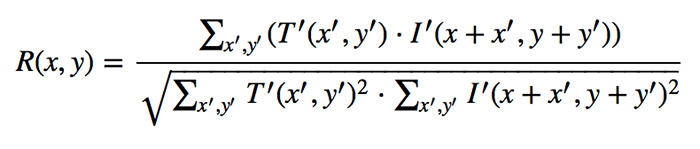

Este proceso es similar a un windowing, donde la ventana es la imagen de referencia. 
Como verás es un proceso iterativo, dispendioso, pero en el que puedes poner tu creatividad a funcionar para lograrlo de forma eficiente.

#### _TIP: realiza el proceso un batch pequeño de imagenes, o solo sobre un par de ellas, hasta que estés satisfecho con el resultado. Una vez esté listo, ESCALA el procedimiento para operar todas la imagenes lo más rápido posible.!_

In [18]:
import os
import cv2
import numpy as np
from PIL import Image
from timeit import default_timer as timer
import matplotlib.pyplot as plt

# Inicio del temporizador
start = timer()

# Definir las rutas de las carpetas
carpeta_entrada = "processed512"
carpeta_separada = "Imagenes_separadas"
carpeta_cortada_principal = "separadas_cortadas"
carpeta_procesadas = "Imagenes_procesadas_separadas"
carpeta_plantillas = "plantillas"

# Crear las carpetas de destino si no existen
if not os.path.exists(carpeta_separada):
    os.makedirs(carpeta_separada)
if not os.path.exists(carpeta_cortada_principal):
    os.makedirs(carpeta_cortada_principal)
if not os.path.exists(carpeta_procesadas):
    os.makedirs(carpeta_procesadas)

# Función para procesar y separar las imágenes
def procesar_y_separar_imagenes(carpeta_entrada, carpeta_salida):
    tipos = ["box", "circ", "cross"]
    for tipo in tipos:
        subcarpeta = os.path.join(carpeta_salida, tipo)
        if not os.path.exists(subcarpeta):
            os.makedirs(subcarpeta)

    contador = {tipo: 1 for tipo in tipos}
    for nombre_archivo in os.listdir(carpeta_entrada):
        ruta_entrada = os.path.join(carpeta_entrada, nombre_archivo)
        if os.path.isfile(ruta_entrada):
            for tipo in tipos:
                if nombre_archivo.startswith(tipo):
                    imagen_procesada = procesar_imagen(ruta_entrada)
                    nombre_salida = f"{tipo}_{contador[tipo]:03d}.png"
                    ruta_salida = os.path.join(carpeta_salida, tipo, nombre_salida)
                    cv2.imwrite(ruta_salida, imagen_procesada)
                    contador[tipo] += 1
                    break

# Función para procesar la imagen (mantener solo el canal rojo)
def procesar_imagen(ruta_imagen):
    array_imagen = cv2.imread(ruta_imagen)
    canal_rojo = array_imagen[:, :, 2]
    imagen_roja = np.zeros_like(array_imagen)
    imagen_roja[:, :, 2] = canal_rojo
    return imagen_roja

# Procesar y separar todas las imágenes en la carpeta de entrada
procesar_y_separar_imagenes(carpeta_entrada, carpeta_separada)

# Función para recortar la imagen
def recortar_imagen(ruta_imagen, nombre_imagen, carpeta_1_4):
    with Image.open(ruta_imagen) as img:
        if img.size == (512, 512):
            img_recortada = img.crop((0, 0, 256, 256))
            ruta_imagen_recortada = os.path.join(carpeta_1_4, nombre_imagen)
            img_recortada.save(ruta_imagen_recortada)
            return ruta_imagen_recortada
        else:
            print(f"La imagen {nombre_imagen} no tiene el tamaño esperado de 512x512 píxeles.")
            return None

# Recorrer todas las subcarpetas en la carpeta separada y recortar las imágenes
for tipo in ["box", "circ", "cross"]:
    carpeta_tipo_original = os.path.join(carpeta_separada, tipo)
    carpeta_tipo_cortada = os.path.join(carpeta_cortada_principal, tipo)
    
    if not os.path.exists(carpeta_tipo_cortada):
        os.makedirs(carpeta_tipo_cortada)
    
    for nombre_imagen in os.listdir(carpeta_tipo_original):
        ruta_imagen = os.path.join(carpeta_tipo_original, nombre_imagen)
        recortar_imagen(ruta_imagen, nombre_imagen, carpeta_tipo_cortada)

# Función para realizar template matching
def template_matching(imagen_recortada, plantillas):
    img = cv2.imread(imagen_recortada, 0)
    mejor_coincidencia = None
    mejor_valor = float('inf')
    mejor_nombre = None
    
    for nombre_plantilla, ruta_plantilla in plantillas.items():
        template = cv2.imread(ruta_plantilla, 0)
        res = cv2.matchTemplate(img, template, cv2.TM_SQDIFF)
        min_val, _, _, _ = cv2.minMaxLoc(res)
        
        if min_val < mejor_valor:
            mejor_valor = min_val
            mejor_coincidencia = ruta_plantilla
            mejor_nombre = nombre_plantilla
    
    return mejor_nombre

# Definir las plantillas
plantillas = {nombre: os.path.join(carpeta_plantillas, nombre) for nombre in os.listdir(carpeta_plantillas)}

# Variables para contar las clasificaciones
true_positives = 0
false_positives = 0
true_negatives = 0
false_negatives = 0

# Listas para guardar ejemplos verdaderos y falsos
ejemplos_verdaderos = []
ejemplos_falsos = []

# Recorrer todas las subcarpetas en la carpeta cortada y realizar template matching
for tipo in ["box", "circ", "cross"]:
    carpeta_tipo_cortada = os.path.join(carpeta_cortada_principal, tipo)
    for nombre_imagen in os.listdir(carpeta_tipo_cortada):
        ruta_imagen_recortada = os.path.join(carpeta_tipo_cortada, nombre_imagen)
        mejor_nombre = template_matching(ruta_imagen_recortada, plantillas)
        if mejor_nombre:
            nuevo_nombre = f"{os.path.splitext(nombre_imagen)[0]}_{mejor_nombre}.png"
            nueva_ruta = os.path.join(carpeta_procesadas, nuevo_nombre)
            os.rename(ruta_imagen_recortada, nueva_ruta)
            
            # Clasificar como verdadero o falso
            if tipo in mejor_nombre:  # Ajustar esta lógica según el criterio correcto
                true_positives += 1
                if len(ejemplos_verdaderos) < 2:
                    ejemplos_verdaderos.append(nueva_ruta)
            else:
                false_positives += 1
                if len(ejemplos_falsos) < 2:
                    ejemplos_falsos.append(nueva_ruta)

            print(f"Renombrada {ruta_imagen_recortada} a {nueva_ruta}")

# Fin del temporizador
end = timer()
print(f"Tiempo de ejecución: {end - start} segundos")


Renombrada separadas_cortadas\box\box_001.png a Imagenes_procesadas_separadas\box_001_box.png.png
Renombrada separadas_cortadas\box\box_002.png a Imagenes_procesadas_separadas\box_002_circ.png.png
Renombrada separadas_cortadas\box\box_003.png a Imagenes_procesadas_separadas\box_003_box.png.png
Renombrada separadas_cortadas\box\box_004.png a Imagenes_procesadas_separadas\box_004_box.png.png
Renombrada separadas_cortadas\box\box_005.png a Imagenes_procesadas_separadas\box_005_box.png.png
Renombrada separadas_cortadas\box\box_006.png a Imagenes_procesadas_separadas\box_006_box.png.png
Renombrada separadas_cortadas\box\box_007.png a Imagenes_procesadas_separadas\box_007_circ.png.png
Renombrada separadas_cortadas\box\box_008.png a Imagenes_procesadas_separadas\box_008_circ.png.png
Renombrada separadas_cortadas\box\box_009.png a Imagenes_procesadas_separadas\box_009_box.png.png
Renombrada separadas_cortadas\box\box_010.png a Imagenes_procesadas_separadas\box_010_circ.png.png
Renombrada separ

# 5. Clasificación
De cada operación realizada de matching, obtendrás valores para inferir si la imagen bajo estudio corresponde con alguna de las 3 categorías: cross, box, circle.

Debes almacenar cada resultado obtenido para cada imagen, hallar el error de clasificación y generar un informe del error general al clasificar todas las imagenes.

Presenta aquí el resultado de clasificación numérico, así como  dos ejemplos verdaderos y dos ejemplos falsos de imagenes clasificadas.


Verdaderos Positivos: 7499
Falsos Positivos: 6829


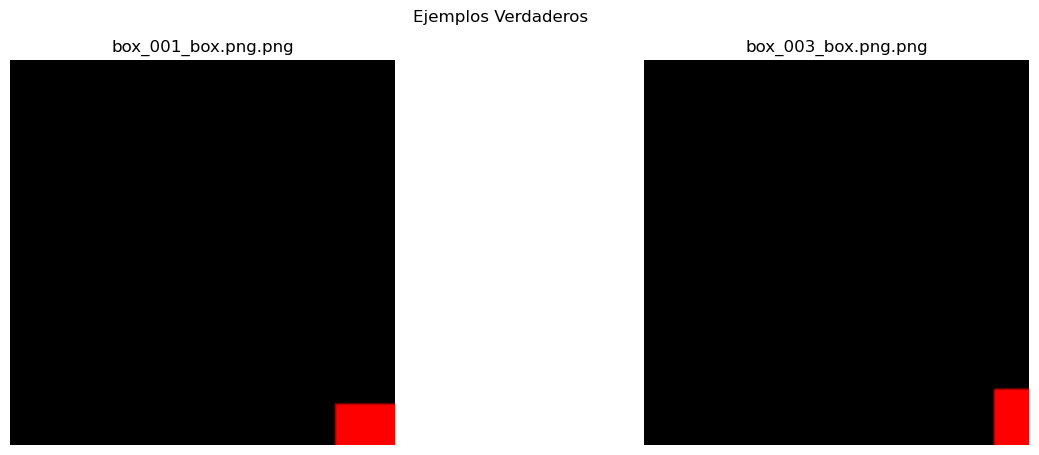

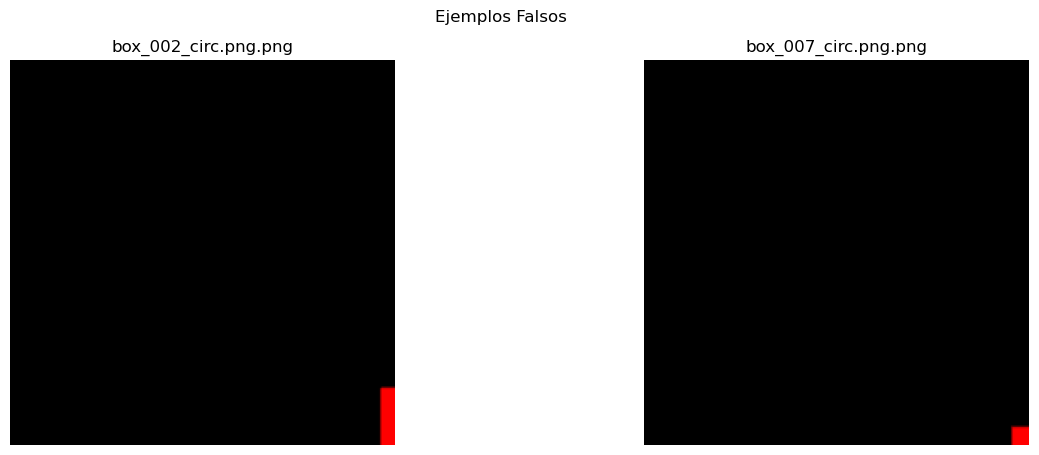

In [21]:
# Resultados de clasificación
print(f"Verdaderos Positivos: {true_positives}")
print(f"Falsos Positivos: {false_positives}")

# Mostrar ejemplos
def mostrar_ejemplos(ejemplos, titulo):
    fig, axs = plt.subplots(1, len(ejemplos), figsize=(15, 5))
    fig.suptitle(titulo)
    for ax, ejemplo in zip(axs, ejemplos):
        img = Image.open(ejemplo)
        ax.imshow(img)
        ax.set_title(os.path.basename(ejemplo))
        ax.axis('off')
    plt.show()

if ejemplos_verdaderos:
    mostrar_ejemplos(ejemplos_verdaderos, "Ejemplos Verdaderos")

if ejemplos_falsos:
    mostrar_ejemplos(ejemplos_falsos, "Ejemplos Falsos")


# 6. Medición
Recuerda que debes imprimir el tiempo que tarda tu algoritmo en procesar todas las imagenes en la base de datos. Usa el siguiente fragmento de código, ubicando el inicio y fin donde corresponda.





In [24]:
from timeit import default_timer as timer

start = timer()

print(23*2.3)

end = timer()
print(end - start)



52.9
7.560010999441147e-05
